In [133]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal

sys.path.append('../Scripts')
from deafrica_datahandling import wofs_fuser

In [2]:
dc = datacube.Datacube(app='gaussian_DEM')

In [3]:
# Define the central point of the area of interest
lat, lon = -19.85, 34.70

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

In [4]:
# Create a query
dem30_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-30, 30)
}

# Create a query for a 50 meter dem ~ we do this becuase we want the extent, shape and geotransform
dem50_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-50, 50)
}

#load elevation
elevation_array30 = dc.load(product ='srtm', **dem30_query)
elevation_array50 = dc.load(product ='srtm', **dem50_query)

#elevation_array

In [5]:
#convert to an dataArray (rather an Dataset) and select single time-slice
dem30 = elevation_array30[['elevation']].isel(time=0).to_array()
dem50 = elevation_array50[['elevation']].isel(time=0).to_array()

In [89]:
dem50

<xarray.DataArray (variable: 1, y: 448, x: 424)>
array([[[8, 8, 7, ..., 7, 6, 7],
        [7, 7, 8, ..., 7, 8, 7],
        [7, 6, 8, ..., 7, 9, 7],
        ...,
        [4, 4, 7, ..., 0, 0, 0],
        [5, 4, 6, ..., 0, 0, 0],
        [6, 6, 5, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2019-09-09
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int32 2736
  * variable     (variable) <U9 'elevation'
Attributes:
    crs:           EPSG:2736
    grid_mapping:  spatial_ref

In [152]:
size = 50

In [153]:
from scipy.signal import fftconvolve

def gaussian_blur1d(in_array, size):
        #check validity
        try:
            if 0 in in_array.shape:
                raise Exception("Null array can't be processed!")
        except TypeError:
            raise Exception("Null array can't be processed!")
            
        # expand in_array to fit edge of kernel
        padded_array = np.pad(in_array, size, 'symmetric').astype(float)
        
        # build kernel
        x, y = np.mgrid[-size:size + 1, -size:size + 1]
        g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
        g = (g / g.sum()).astype(float)
        
        # do the Gaussian blur
        out_array = fftconvolve(padded_array, g, mode='valid')
        return out_array.astype(in_array.dtype)

In [154]:
Gblur = gaussian_blur1d(dem50.squeeze(), size=50)

In [155]:
Gblur

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int16)

In [156]:
#create an DataArray object
da = xr.DataArray(data = Gblur,
                  coords = {'y': dem50.y, 
                            'x': dem50.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])
da

<xarray.DataArray (y: 448, x: 424)>
array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int64 2736
Attributes:
    crs:      EPSG:2736

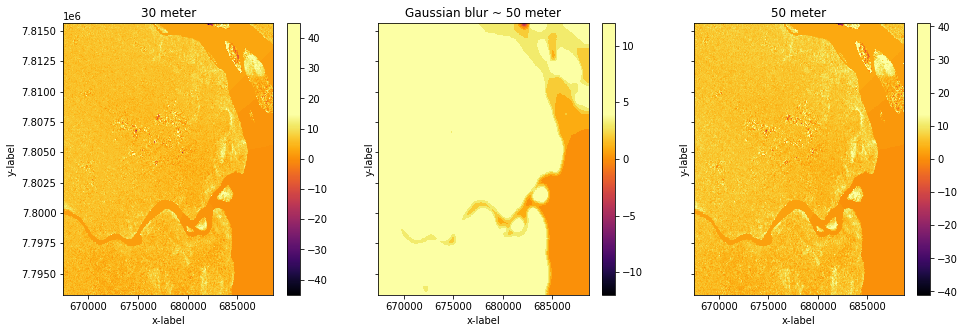

In [157]:
# Plot the elevation data
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
dem30.plot(ax=axs[0], cmap=cmap_terrain)
axs[0].set_title('30 meter')

da.plot(ax=axs[1], cmap=cmap_terrain)
axs[1].set_title('Gaussian blur ~ 50 meter')

dem50.plot(ax=axs[2], cmap=cmap_terrain)
axs[2].set_title('50 meter')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

plt.show()

In [158]:
print(dem30.squeeze().shape)
print(da.shape)
print(dem50.squeeze().shape)
print('')
#print(dem.crs)
print(dem30.size)
print(da.size)
print(dem50.size)

(746, 706)
(448, 424)
(448, 424)

526676
189952
189952


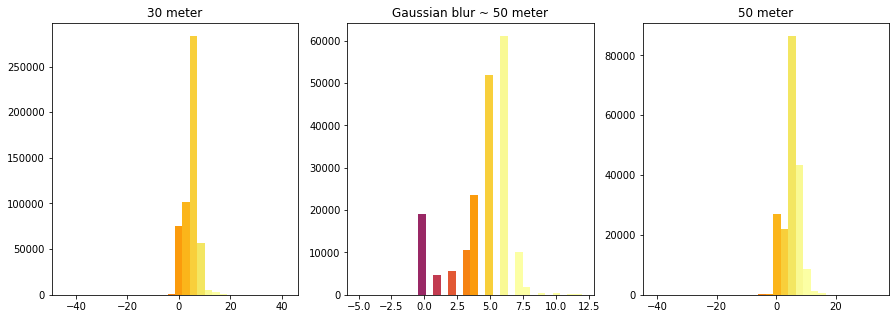

In [159]:
# Plot instance
f, ax = plt.subplots(1, 3, figsize=(15, 5))

# histogram.
n, bins, patches = dem30.squeeze().plot.hist(ax=ax[0],
                                           color="purple",
                                           bins=30)                 # feel free to change these 
ax[0].set_title('30 meter')
bin_centers = 0.8 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins2, patches = da.plot.hist(ax=ax[1],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[1].set_title('Gaussian blur ~ 50 meter')
bin_centers2 = 0.8 * (bins2[:-1] + bins2[1:])
# scale values to interval [0,1]
col2 = bin_centers2 - min(bin_centers2)
col2 /= max(col2)
for c, p2 in zip(col2, patches):
    plt.setp(p2, 'facecolor', cmap_terrain(c))

# histogram.
n, bins3, patches = dem50.plot.hist(ax=ax[2],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[2].set_title('50 meter')
bin_centers3 = 0.8 * (bins3[:-1] + bins3[1:])
# scale values to interval [0,1]
col3 = bin_centers3 - min(bin_centers3)
col3 /= max(col3)
for c, p3 in zip(col3, patches):
    plt.setp(p3, 'facecolor', cmap_terrain(c))

plt.show()

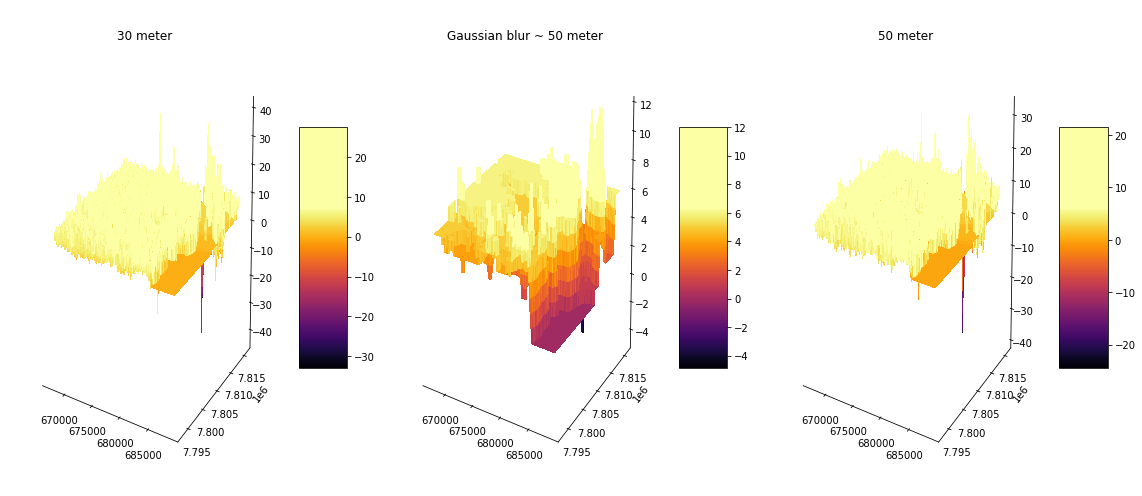

In [160]:
# set up a figure 
fig = plt.figure(figsize=(16, 7))

#do one image
ax1 = fig.add_subplot(131,projection='3d')
#transform the image
xres = elevation_array30.geobox.transform[0]
yres = elevation_array30.geobox.transform[4]
X = np.arange(dem30.geobox.transform[2], dem30.geobox.transform[2] + dem30.shape[1:][1]*xres, xres)
Y = np.arange(dem30.geobox.transform[5], dem30.geobox.transform[5] + dem30.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf1 = ax1.plot_surface(X, Y, dem30.squeeze(), rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=False, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax1.view_init(20, 300)
fig.colorbar(surf1, shrink=0.5, aspect=5)
ax1.set_title('30 meter')

#do another image
ax2 = fig.add_subplot(132,projection='3d')
#transform the image
xres = elevation_array50.geobox.transform[0]
yres = elevation_array50.geobox.transform[4]
X = np.arange(dem50.geobox.transform[2], dem50.geobox.transform[2] + dem50.shape[1:][1]*xres, xres)
Y = np.arange(dem50.geobox.transform[5], dem50.geobox.transform[5] + dem50.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# make the panes transparent
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax2.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf2 = ax2.plot_surface(X, Y, da.squeeze(), rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=False, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax2.view_init(20, 300)
fig.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title('Gaussian blur ~ 50 meter')


#do another image
ax3 = fig.add_subplot(133,projection='3d')
#transform the image
xres = elevation_array50.geobox.transform[0]
yres = elevation_array50.geobox.transform[4]
X = np.arange(dem50.geobox.transform[2], dem50.geobox.transform[2] + dem50.shape[1:][1]*xres, xres)
Y = np.arange(dem50.geobox.transform[5], dem50.geobox.transform[5] + dem50.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# make the panes transparent
ax3.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax3.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax3.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax3.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax3.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax3.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf3 = ax3.plot_surface(X, Y, dem50.squeeze(), rstride=2, cstride=2, cmap=cmap_terrain, linewidth=0, antialiased=False, zorder=2)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax3.view_init(20, 300)
fig.colorbar(surf3, shrink=0.5, aspect=5)
ax3.set_title('50 meter')

plt.tight_layout() 
plt.show()

### Inundation Senario 

In [75]:
flood_range = 7

In [131]:
mask = {}

for k in range(flood_range):
    mask[k] = da <= k

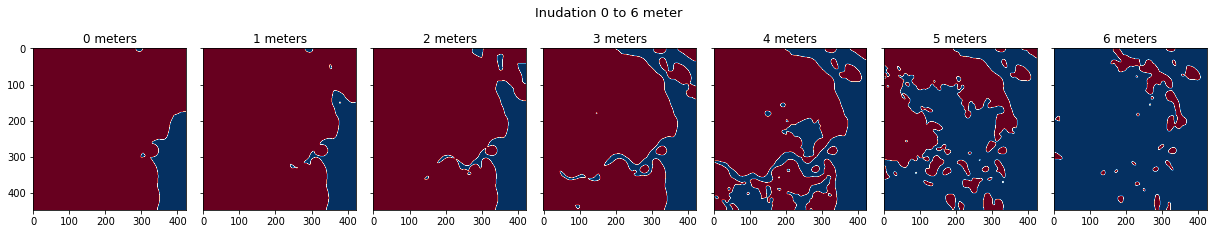

In [132]:
_, axs = plt.subplots(1, len(mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(mask, axs):
    ax.imshow(mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inudation 0 to 6 meter', size = 13, y = 0.6)
plt.tight_layout()
plt.show()

In [134]:
# Create a query
wofs_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'time': ('2018-01-01', '2018-12-30'),
    'resolution': (-30, 30)
}

# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2_annual_summary", group_by="solar_day",
                            fuse_func=wofs_fuser, **wofs_query)

In [135]:
mask_with90 = wofls.squeeze().frequency >= 0.9
mask_with90.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

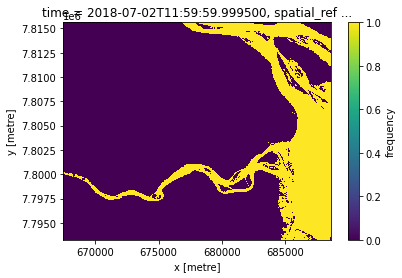

In [136]:
#plot
mask_with90.plot()

### New Inundation Senario with WOfS removed

In [137]:
new_mask = {}

for i in range(flood_range):
    new_mask[i] = mask[i].where(wofls.squeeze().frequency <= 0.9)

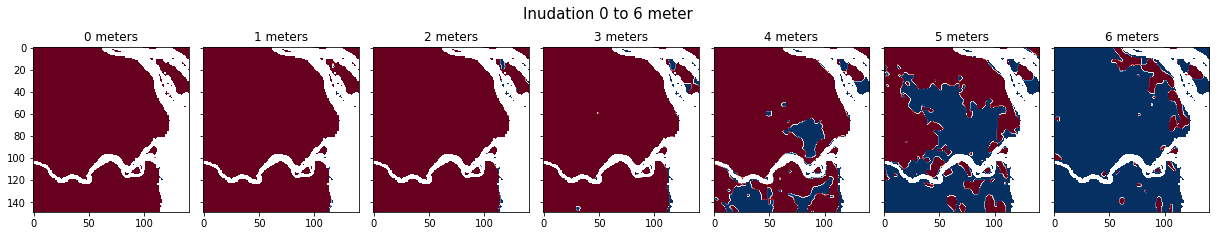

In [138]:
_, axs = plt.subplots(1, len(new_mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(new_mask, axs):
    cb = ax.imshow(new_mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')

#plt.colorbar(cb)                                                      #perhaps a colorbar would be informative - add divider?
plt.suptitle('Inudation 0 to 6 meter', size = 15, y = 0.6)
plt.tight_layout()
plt.show()

### Compare with SAR ~ Sentinel 1: Beira_March 2019

In [139]:
#dataset = gdal.Open('../Supplementary_data/WorkingFolder/Beira_19032019_flooding.tif')#, gdal.GA_ReadOnly) 
dataset = gdal.Open('../Supplementary_data/WorkingFolder/beira_un-spider2.tif')
# Note GetRasterBand() takes band no. starting from 1 not 0
#band = dataset.GetRasterBand(1)
arr = dataset.ReadAsArray()

In [140]:
import matplotlib.gridspec as gridspec

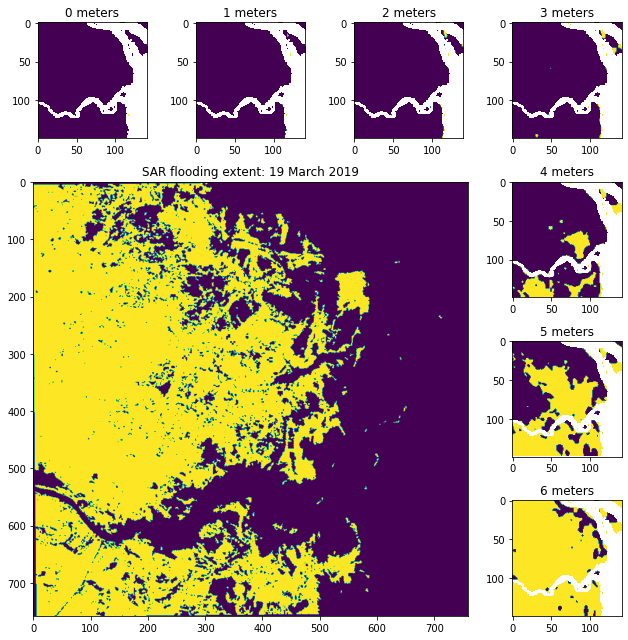

In [141]:
fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(new_mask[0].squeeze())
a1.set_title('0 meters')
a2.imshow(new_mask[1].squeeze())
a2.set_title('1 meters')
a3.imshow(new_mask[2].squeeze())
a3.set_title('2 meters')
a4.imshow(new_mask[3].squeeze())
a4.set_title('3 meters')
a5.imshow(arr) #a1.set_title('exp')
#a5.imshow(mask_with90, zorder=2, alpha=0.3)
a5.set_title('SAR flooding extent: 19 March 2019')
a6.imshow(new_mask[4].squeeze())
a6.set_title('4 meters')
a7.imshow(new_mask[5].squeeze())
a7.set_title('5 meters')
a8.imshow(new_mask[6].squeeze())
a8.set_title('6 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')

plt.tight_layout()
plt.show()